# Introduction on Tidy3D working principles

This notebook will walk through the basic working principles of the Tidy3D front end, including setting up and post processing simulation results.

Note that this content serves as a reference for the details of operating the front end, but a lot of content is covered indirectly in the other [example notebooks](https://www.flexcompute.com/tidy3d/examples/).

In [1]:
# First, let's import the main packages we'll need
import numpy as np
import matplotlib.pylab as plt
import tidy3d as td


## Basics

A Tidy3D simulation is essentially a python class that combines many Tidy3D "components", which store the specification for how we will run the simulation on our servers.

Here we will discuss some of the basics that apply to all of these components.

Topics covered will include:

- Defining Tidy3D components.

- Saving and loading from file.

- Getting help / debugging.

- logging.

### Background

All Tidy3d components are defined using the [pydantic](https://pydantic-docs.helpmanual.io) package.  This means that each tidy3d object corresponds to a data structure that has rigidly defined allowable types and values, which get validated automatically whenever you initialize an object.

This has several advantages, including.

- Catching bugs in the tidy3d components as early as possible.

- Automatically generated schema for tidy3d simulation specifications.

- Simple and reliable IO, including exporting to various formats such as dictionaries or json.

### Defining Tidy3d Components

It also requires a bit more work on the user side to define these components, for example

- All tidy3d components must use keyword arguments in their definitions, eg. `Medium(2.0)` becomes `Medium(permittivity=2.0)` to be explicit.

- Components are immutable to avoid complications from not validating changes on components. This means modifying a component requires calling `new_obj = old_obj.updated_copy(val=new_val, ...)`.

However, these decisions were made to make the overall use of Tidy3D more explicit and ensure that components are safely validated at all times, which pays off in the long run.

Here's one example of what would happen if a user tried to pass fields (in this case, the relative permittivity of a medium) without using keyword arguments), followed by the correct way. We see that the positional argument construction fails. This is good practice in general to avoid bugs, but pydantic and Tidy3D require it.

In [2]:
# wrong way
try:
    td.Medium(2.0)
except Exception as e:
    td.log.info(e)

# correct way
m = td.Medium(permittivity=2.0)


### Saving and Loading Tidy3d Components

All tidy3d components can be saved to file as json or yaml format using the `instance.to_file(path)` and `class.from_file(path)` methods.

For example, let's save and load a [td.Box](../api/_autosummary/tidy3d.Box.html) instance.

In [3]:
my_box = td.Box(center=(1, 2, 3), size=(2, 2, 3))

my_box.to_file("data/box.json")

# note, `from_file` is a @classmethod so it can be called from `td.Box` or `my_box`.
your_box = td.Box.from_file("data/box.json")

print(my_box)
print(your_box)
print(my_box == your_box)


type='Box' center=(1.0, 2.0, 3.0) size=(2.0, 2.0, 3.0)
type='Box' center=(1.0, 2.0, 3.0) size=(2.0, 2.0, 3.0)
True


Similarly, the component can be converted to a `dict` or `str` in json format. Many other options exist and the [pydantic documentation](https://docs.pydantic.dev/usage/exporting_models/) is a good place to see what else is supported.

In [4]:
print(my_box.json())
print(my_box.dict())


{"type": "Box", "center": [1.0, 2.0, 3.0], "size": [2.0, 2.0, 3.0]}
{'type': 'Box', 'center': (1.0, 2.0, 3.0), 'size': (2.0, 2.0, 3.0)}


### Getting Help

Sometimes you might want to get some information about a component without needing to look at the documentation.  For this, each tidy3d component has a `.help()` method that will print out information about the stored data inside of the component.

Here's an example.

In [5]:
monitor = td.FieldMonitor(size=(2, 2, 0), freqs=[200e12], name="monitor")

monitor.help()


╭─────────────────────── <class 'tidy3d.components.monitor.FieldMonitor'> ───────────────────────╮
│ :class:`Monitor` that records electromagnetic fields in the frequency domain.                  │
│                                                                                                │
│ ╭────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ FieldMonitor(                                                                              │ │
│ │ │   type='FieldMonitor',                                                                   │ │
│ │ │   center=(0.0, 0.0, 0.0),                                                                │ │
│ │ │   size=(2.0, 2.0, 0.0),                                                                  │ │
│ │ │   name='monitor',                                                                        │ │
│ │ │   interval_space=(1, 1, 1),                                                              │ │
│ │ │   colocate=True,                                                                         │ │
│ │ │   freqs=(200000000000000.0,),                                                            │ │
│ │ │   apodization=ApodizationSpec(                                                           │ │
│ │ │   │   start=None,                                                                        │ │
│ │ │   │   end=None,                                                                          │ │
│ │ │   │   width=None,                                                                        │ │
│ │ │   │   type='ApodizationSpec'                                                             │ │
│ │ │   ),                                                                                     │ │
│ │ │   fields=('Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz')                                            │ │
│ │ )                                                                                          │ │
│ ╰────────────────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                                │
│     apodization = ApodizationSpec(start=None, end=None, width=None, type='ApodizationSpec')    │
│    bounding_box = Box(type='Box', center=(0.0, 0.0, 0.0), size=(2.0, 2.0, 0.0))                │
│          bounds = ((-1.0, -1.0, 0.0), (1.0, 1.0, 0.0))                                         │
│          center = (0.0, 0.0, 0.0)                                                              │
│        colocate = True                                                                         │
│          fields = ('Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz')                                         │
│           freqs = (200000000000000.0,)                                                         │
│ frequency_range = (200000000000000.0, 200000000000000.0)                                       │
│        geometry = Box(type='Box', center=(0.0, 0.0, 0.0), size=(2.0, 2.0, 0.0))                │
│  interval_space = (1, 1, 1)                                                                    │
│            name = 'monitor'                                                                    │
│     plot_params = PlotParams(                                                                  │
│                       alpha=0.4,                                                               │
│                       edgecolor='orange',                                                      │
│                       facecolor='orange',                                                      │
│                       fill=True,                                                               │
│                       hatch=None,                                                              │
│                       zorder=None,                                                             │
│                       linewidth=3.0,  

Alternatively, one can use the standard `help(cls)` syntax to get a look at the docstring of a component.

In [6]:
# help(td.FieldMonitor) # commented out for brevity


### Logging

Tidy3D logs information based on the following levels ranked from least to most critical.
```
"DEBUG"
"INFO"
"WARNING"
"ERROR"
"CRITICAL"
```
The "logging level" controls what types of messages get shown. The default logging level is `"WARNING"`, which means logging messages of "warning" or more critical ("error", "critical") will be shown, whereas "info" and "debug" messages will not. The "info" and "debug" messages are sometimes useful for the user, but are mainly for debugging purposes.

The user can change this logging level through modifying the `tidy3d.config.logging_level` value, for example
```
tidy3d.config.logging_level = "INFO"
```
will make it so that "info" messages are shown in addition to the "warning", "error", and "critical" messages.

## Core Components

Here we will discuss the core components of the package (sources, monitors, etc) and how they are defined.

Topics covered will include:

- Mediums.

- Geometries.

- Structures.

- Sources.

- Monitors.

- Modes.

- PML / Absorbing boundaries.

- Simulations.

### Mediums

Mediums define the optical properties of the materials within the simulation.

#### PEC
The simplest medium is `td.PEC`, which just signifies a perfect electrical conductor (no E field allowed within).

In [7]:
pec_medium = td.PEC


#### Non-dispersive mediums
Non-dispersive mediums are defined using the [Medium](../api/_autosummary/tidy3d.Medium.html) object and can be specified by either `permittivity` and `conductivity` (optional) values, or from `n`, `k` refractive index values.

In [8]:
lossless_dielectric = td.Medium(permittivity=4.0)
lossy_dielectric = td.Medium(permittivity=4.0, conductivity=1.0)
lossy_dielectric_from_nk = td.Medium.from_nk(n=2.0, k=0.1, freq=150e12)


#### Anisotropic mediums

Tidy3d supports fully anisotropic mediums, but in this example, we will show how to model diagonally anisotropic mediums. See [this tutorial](../notebooks/FullyAnisotropic.html) for the complete guide.

Diagonally anisotropic mediums can be simply defined by specifying three [Medium](../api/_autosummary/tidy3d.Medium.html) objects for the xx, yy, zz components of the permittivity / conductivity tensor.


In [9]:
anisotropic_medium = td.AnisotropicMedium(
    xx=lossless_dielectric, yy=lossy_dielectric, zz=lossy_dielectric_from_nk
)


#### Dispersive mediums

Dispersive mediums can be defined in three ways:

- Imported from our [material_library](../material_library.html).

- Defined directly by specifying the parameters in the various supplied dispersive models.

- Fitted to optical n-k data using the dispersion fitting tool plugin (more info later).

In [10]:
# material library
silver = td.material_library["Ag"]
silver_variants = silver.variants
print("variants for silver include: ", list(silver_variants.keys()))
silver = silver_variants["JohnsonChristy1972"]

# models
lorentz_model = td.Lorentz(eps_inf=2.0, coeffs=[(1, 2, 3), (4, 5, 6)])
sellmeier_model = td.Sellmeier(coeffs=[(1, 2), (3, 4)])


variants for silver include:  ['Rakic1998BB', 'JohnsonChristy1972', 'RakicLorentzDrude1998', 'Yang2015Drude']


### Medium Methods

The complex-valued permittivity of a medium at a given frequency can be sampled using the `.eps_model(freq)` method.

And the n, k values can be plotted over a frequency range using the `.plot(freqs)` method.

complex relative permittivity at freqs_hz = 
	 [4.+359.50207169j 4.+358.42679132j 4.+357.35792415j ... 4. +90.01053372j
 4. +89.94297515j 4. +89.87551792j]



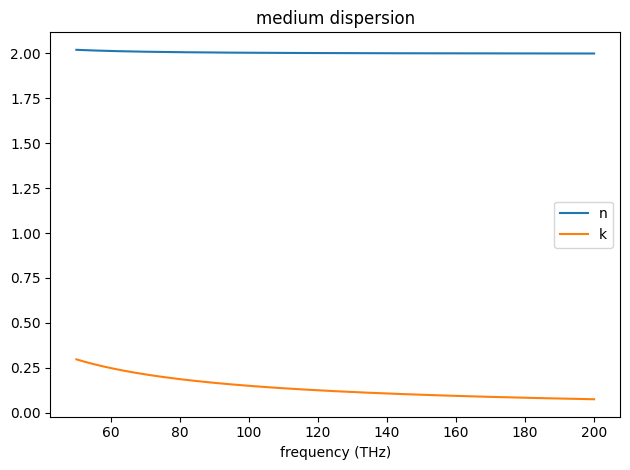

In [11]:
freqs_hz = 1e12 * np.linspace(50, 200, 1001)
print(
    f"complex relative permittivity at freqs_hz = \n\t {lossy_dielectric.eps_model(freqs_hz)}\n"
)

ax = lossy_dielectric_from_nk.plot(freqs_hz)


### Geometries

The new version of Tidy3D introduces [Geometry](../api.html#geometry) objects, which do the heavy lifting for any components with some spatial extent.

There are 5 primitive and 2 compound geometry classes:

- [Box](../api/_autosummary/tidy3d.Box.html)

- [Sphere](../api/_autosummary/tidy3d.Sphere.html)

- [Cylinder](../api/_autosummary/tidy3d.Cylinder.html)

- [Polyslab](../api/_autosummary/tidy3d.PolySlab.html)

- [TriangleMesh](../api/_autosummary/tidy3d.TriangleMesh.html)

- [GeometryGroup](../api/_autosummary/tidy3d.GeometryGroup.html)

- [ClipOperation](../api/_autosummary/tidy3d.ClipOperation.html)

If your device is defined in GDS format, they may be loaded using the `Geometry.from_gds()` static method. Please refer to the [tutorial notebook on GDS importing](../notebooks/GDSImport.html) for more details.

All [Geometry](../api/_autosummary/tidy3d.Geometry.html) objects have many useful methods for checking intersections, bounds, and other properties.

True
False
True
((-1.0, -1.0, -1.0), (1.0, 1.0, 1.0))


╭────────────────── <class 'tidy3d.components.geometry.base.Box'> ───────────────────╮
│ Rectangular prism.                                                                 │
│    Also base class for :class:`Simulation`, :class:`Monitor`, and :class:`Source`. │
│                                                                                    │
│ ╭────────────────────────────────────────────────────────────────────────────────╮ │
│ │ Box(type='Box', center=(0.0, 0.0, 0.0), size=(2.0, 2.0, 2.0))                  │ │
│ ╰────────────────────────────────────────────────────────────────────────────────╯ │
│                                                                                    │
│ bounding_box = Box(type='Box', center=(0.0, 0.0, 0.0), size=(2.0, 2.0, 2.0))       │
│       bounds = ((-1.0, -1.0, -1.0), (1.0, 1.0, 1.0))                               │
│       center = (0.0, 0.0, 0.0)                                                     │
│     geometry = Box(type='Box', center=(0.0, 0.0, 0.0), size=(2.0, 2.0, 2.0))       │
│  plot_params = PlotParams(                                                         │
│                    alpha=1.0,                                                      │
│                    edgecolor=None,                                                 │
│                    facecolor=None,                                                 │
│                    fill=True,                                                      │
│                    hatch=None,                                                     │
│                    zorder=None,                                                    │
│                    linewidth=1.0,                                                  │
│                    type='PlotParams'                                               │
│                )                                                                   │
│         size = (2.0, 2.0, 2.0)                                                     │
│         type = 'Box'                                                               │
│    zero_dims = []                                                                  │
╰────────────────────────────────────────────────────────────────────────────────────╯

None
False
[False False  True False False]


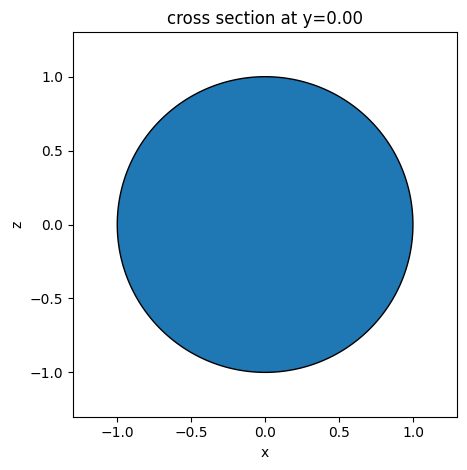

In [12]:
s1 = td.Sphere(radius=1, center=(0, 0, 0))
s2 = td.Box(center=(1, 1, 1), size=(1, 1, 1))

# do two geometric objects intersect?
print(s1.intersects(s2))

# does the object intersect a plane?
print(s1.intersects_plane(z=10))

# get polygons that intersect sphere at plane x=0
print(s1.intersects_plane(x=0))

# get bounds (rmin, rmax) of geometry
print(s1.bounds)

# get td.Box() for bounding box of geometry
print(s1.bounding_box.help())

# evaluate whether point(s) are inside of geometry
print(s1.inside(x=0, y=1, z=1))
print(s1.inside(x=np.linspace(-1, 1, 5), y=np.zeros(5), z=np.ones(5)))

# plot the geometry at a cross sectional plane
ax = s1.plot(y=0)


Note, because simulations, monitors, and sources all are defined spatially, they inherit from [Box](../api/_autosummary/tidy3d.Box.html) and contain these methods as well, which can come in handy when doing validation.

### Structures

A [Structure](../api/_autosummary/tidy3d.Structure.html) is a component that simply contains a [Geometry](../api.html#geometry) and a [Medium](../api.html#mediums).  It therefore defines an object in the simulation with some geometry and optical properties, such as a waveguide or slab.

In [13]:
dielectric_box = td.Structure(
    geometry=td.Box(center=(0, 0, 0), size=(1, 1, 1)),
    medium=td.Medium(permittivity=2.0),
)


### Sources

Sources define how the electromagnetic current is injected into the simulation to give rise to fields. There are several types of sources, each generally defines some spatial or polarization properties of the source and also contain a `source_time` field, which defines the time dependence. As an example

In [14]:
# define time dependence
gaussian = td.GaussianPulse(freq0=150e12, fwidth=10e12)

# z polarized dipole at origin
dipole = td.UniformCurrentSource(
    center=(0, 0, 0), size=(0, 0, 0), source_time=gaussian, polarization="Ez"
)

# z polarized plane wave propagating in -x
plane_wave = td.PlaneWave(
    center=(0, 0, 0),
    size=(0, td.inf, td.inf),
    source_time=gaussian,
    pol_angle=np.pi / 2,
    direction="-",
)


### Monitors

Since it would be impractical to return the entire time series of all of the field data solved for by FDTD, "monitors" are specifications that tell Tidy3D what data should be returned by the solver.

The following monitors measure their corresponding values in the frequency-domain

- [FieldMonitor](../api/_autosummary/tidy3d.FieldMonitor.html)

- [FluxMonitor](../api/_autosummary/tidy3d.FluxMonitor.html)

- [ModeMonitor](../api/_autosummary/tidy3d.ModeMonitor.html)

And the following measure their values in the time-domain

- [FieldTimeMonitor](../api/_autosummary/tidy3d.FieldTimeMonitor.html)

- [FluxTimeMonitor](../api/_autosummary/tidy3d.FluxTimeMonitor.html)

There are also various monitors for field projections, diffraction efficiency, and other values. The [API reference](https://docs.flexcompute.com/projects/tidy3d/en/stable/api.html#monitors) lists each of the monitor types, for reference.

Note: all monitors must be *named* (have a `name: str` field supplied).  The data returned by the server will be indexed by the monitor name and accessed by the user using that name.

In [15]:
# measures Ex, Ey, Hz fields on the plane at frequency 150THz
mon1 = td.FieldMonitor(
    center=(1, 0, 0),
    size=(td.inf, td.inf, 0),
    fields=["Ex", "Ey", "Hz"],
    freqs=[150e12],
    name="fields_at_150THz",
)

# measures time dependence of flux through a plane every 5 time steps between a window of (start, stop)
mon2 = td.FluxTimeMonitor(
    center=(1, 0, 0),
    size=(td.inf, td.inf, 0),
    start=1e-13,
    stop=3e-13,
    interval=5,
    name="flux_over_time",
)


### Modes

Modes (for sources and monitors) are specified using a [ModeSpec](../api/_autosummary/tidy3d.ModeSpec.html) object. This component contains all of the specifications needed for the mode solver to know which modes to inject or measure in the [ModeSource](../api/_autosummary/tidy3d.ModeSource.html) and [ModeMonitor](../api/_autosummary/tidy3d.ModeMonitor.html) objects, such as the number of modes, mode index, or a target mode effective index.

For example:

In [16]:
# default mode solver spec (returns first mode)
fundamental = td.ModeSpec()

# tell the mode solver to return 4 modes
first_4_modes = td.ModeSpec(num_modes=4)

# have mode solver return 4 modes around the target effective index
complicated = td.ModeSpec(num_modes=4, target_neff=2.0)


Using the mode specifications, we can make modal sources or monitors similar to before.

In [17]:
# inject the fundamental mode
mode_source = td.ModeSource(
    center=(0, 0, -1),
    size=(td.inf, td.inf, 0),
    source_time=gaussian,
    mode_spec=fundamental,
    mode_index=0,
    direction="+",
)

# do modal decomposition and return amplitude data for the first 4 modes
mode_mon = td.ModeMonitor(
    center=(0, 0, +1),
    size=(td.inf, td.inf, 0),
    freqs=freqs_hz,
    mode_spec=first_4_modes,
    name="modes",
)


The [ModeSolver](../api/_autosummary/tidy3d.plugins.mode.ModeSolver.html) is designed to help users come up with the correct [ModeSpec](../api/_autosummary/tidy3d.ModeSpec.html) for their problem, at which point it can be used directly in [ModeSource](../api/_autosummary/tidy3d.ModeSource.html) and [ModeMonitor](../api/_autosummary/tidy3d.ModeMonitor.html) objects without setting it explicitly using a [Simulation](../api/_autosummary/tidy3d.Simulation.html) method.  For more details, refer to the [mode solver tutorial notebook](../notebooks/ModeSolver.html).

### Absorbing Boundaries

Absorbing boundaries are defined as one of three types of boundaries

- [td.PML()](../api/_autosummary/tidy3d.PML.html) defines a standard PML, with an adjustable number of layers.

- [td.StablePML()](../api/_autosummary/tidy3d.StablePML.html) defines a PML with 'stable' profile, which can reduce divergence at the expense of more layers.

- [td.Absorber()](../api/_autosummary/tidy3d.Absorber.html) defines adiabatically increasing conductivity values at the edges of the simultion, which can dramatically improve stability of simulations involving dispersive materials, again at the expense of more layers.

As before, these layers *add* to the simulation size defined in [Simulation](../api/_autosummary/tidy3d.Simulation.html).

Also as before, it is important to extend any structures all the way through the PML if they are meant to be touching the simulation boundary on that side.

To define a sequence of PML layers on the x, y, z sides of the simulation, one may use the convenience functions provided in [td.BoundarySpec()](../api/_autosummary/tidy3d.BoundarySpec.html) and [td.Boundary()](../api/_autosummary/tidy3d.Boundary.html), as shown below.

Default PML boundaries are always used on each side of the simulation, so if a boundary is not specified along a dimension, the simulation will have PML on that boundary.

In [18]:
# standard absorber on x, PML with 20 layers on y, no PML on z (periodic BC)
boundary_spec = td.BoundarySpec(
    x=td.Boundary.absorber(), y=td.Boundary.pml(num_layers=20), z=td.Boundary.periodic()
)


### Simulations

Finally, the [Simulation](../api/_autosummary/tidy3d.Simulation.html) objects contain all of the specifications needed to run the Tidy3D simulation and contain all of the previous components.

A few notes:

- [Simulation](../api/_autosummary/tidy3d.Simulation.html) accepts an optional `medium` parameter, specifying the background medium (air by default).

- Each simulation must define the discretization using a `grid_spec`, which specifies how the grid is to be generated along each of the three directions. These are discussed in more detail [here](../notebooks/AutoGrid.html).

In [19]:
sim = td.Simulation(
    size=(4, 4, 4),
    grid_spec=td.GridSpec.uniform(dl=0.2),
    run_time=1e-12,
    boundary_spec=td.BoundarySpec(
        x=td.Boundary.periodic(), y=td.Boundary.pml(), z=td.Boundary.periodic()
    ),
    structures=[dielectric_box],
    sources=[dipole],
    monitors=[mon1, mon2],
)


A defined [Simulation](../api/_autosummary/tidy3d.Simulation.html) also provides several useful methods in addition to the ones inherited from [Box](../api/_autosummary/tidy3d.Box.html).

x=array([-1.9, -1.7, -1.5, -1.3, -1.1, -0.9, -0.7, -0.5, -0.3, -0.1,  0.1,
        0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9]) y=array([-4.3, -4.1, -3.9, -3.7, -3.5, -3.3, -3.1, -2.9, -2.7, -2.5, -2.3,
       -2.1, -1.9, -1.7, -1.5, -1.3, -1.1, -0.9, -0.7, -0.5, -0.3, -0.1,
        0.1,  0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9,  2.1,
        2.3,  2.5,  2.7,  2.9,  3.1,  3.3,  3.5,  3.7,  3.9,  4.1,  4.3]) z=array([-1.9, -1.7, -1.5, -1.3, -1.1, -0.9, -0.7, -0.5, -0.3, -0.1,  0.1,
        0.3,  0.5,  0.7,  0.9,  1.1,  1.3,  1.5,  1.7,  1.9]) type='Coords'


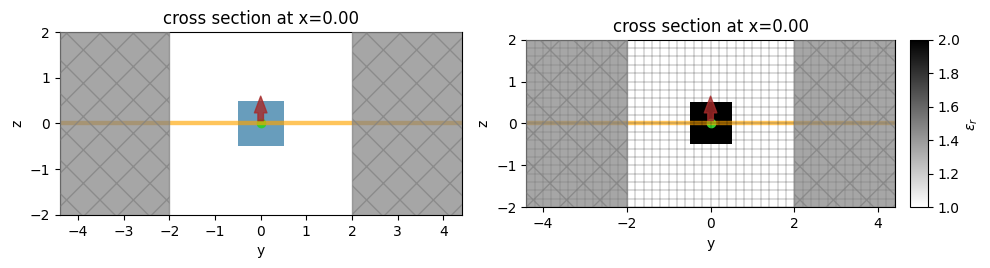

In [20]:
# get permittivity at yee cell centers in a volume defined by a box.
sim.epsilon(td.Box(size=(1, 0, 1)), "centers")

# get a `td.Grid` containing all information about spatial locations in the FDTD / yee grid
print(sim.grid.centers)

# plot the simulation cross section
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))

# plot the structures, PML, sources, mediums
ax1 = sim.plot(x=0, ax=ax1)

# same thing but plot structure in grayscale using permittivity value
ax1 = sim.plot_eps(x=0, ax=ax2)

# add the FDTD grid boundaries
ax2 = sim.plot_grid(x=0, ax=ax2)


## Simulation Submission

Here we discuss the process for submitting, managing, monitoring, and loading simulations from our server.

Topics covered will include:

* [tidy3d.web](../api.html#submitting-simulations) functions.

* working with [tidy3d.web.Job](../api/_autosummary/tidy3d.web.Job.html#tidy3d.web.Job) and [tidy3d.web.Batch](../api/_autosummary/tidy3d.web.Batch.html#tidy3d.web.Batch) convenience containers.

In [21]:
import tidy3d.web as web


### Web interface

The web interface provides a number of basic functions, but usually, the most convenient way to run a single simulation in one line is with [sim_data = web.run(sim)](../api/_autosummary/tidy3d.web.run.html#tidy3d.web.run), which simply performs all of the necessary steps under the hood.

The output of the simultion is a separate data object called a [SimulationData](../api/_autosummary/tidy3d.SimulationData.html), which provides an interface for post processing and visualizing the data.

In [22]:
sim_data = web.run(sim, task_name="web_demo", path="data/data.hdf5", verbose=True)


00:16:29 PST Created task 'web_demo' with task_id                               
             'fdve-5b36954e-cde7-4cba-b74b-62028f172ff0' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=691210;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b36954e-cde7-4cba-b74b-62028f172ff0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=780360;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b36954e-cde7-4cba-b74b-62028f172ff0\taskId]8;;\]8;id=691210;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b36954e-cde7-4cba-b74b-62028f172ff0\=]8;;\]8;id=310186;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b36954e-cde7-4cba-b74b-62028f172ff0\fdve]8;;\]8;id=691210;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b36954e-cde7-4cba-b74b-62028f172ff0\-5b36954e-cde]8;;\
             ]8;id=691210;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b36954e-cde7-4cba-b74b-62028f172ff0\7-4cba-b74b-62028f172ff0']8;;\.

Output()

00:16:30 PST status = queued

Output()

00:16:40 PST status = preprocess

00:16:42 PST Maximum FlexCredit cost: 0.025. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

Output()

00:16:46 PST status = postprocess

00:16:49 PST status = success

             View simulation result at                                          
             ]8;id=35528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b36954e-cde7-4cba-b74b-62028f172ff0\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=966089;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b36954e-cde7-4cba-b74b-62028f172ff0\taskId]8;;\]8;id=35528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b36954e-cde7-4cba-b74b-62028f172ff0\=]8;;\]8;id=536043;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b36954e-cde7-4cba-b74b-62028f172ff0\fdve]8;;\]8;id=35528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b36954e-cde7-4cba-b74b-62028f172ff0\-5b36954e-cde]8;;\
             ]8;id=35528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5b36954e-cde7-4cba-b74b-62028f172ff0\7-4cba-b74b-62028f172ff0']8;;\.

Output()

             loading simulation from data/data.hdf5

00:16:50 PST WARNING: Simulation final field decay value of 0.00665 is greater  
             than the simulation shutoff threshold of 1e-05. Consider running   
             the simulation again with a larger 'run_time' duration for more    
             accurate results.                                                  

> Note: the warning here tells us that we should probably increase the `run_time` of our `Simulation` to ensure the fields properly decay. Since this notebook is just a demonstration and we don't care about the results, we can ignore it in this case.

### Containers and Batching

The convenience containers [Job](../api/_autosummary/tidy3d.web.Job.html#tidy3d.web.Job) and [Batch](../api/_autosummary/tidy3d.web.Batch.html#tidy3d.web.Batch) allow one to manage single and multiple tasks in a more "object oriented" fashion.

They follow the same basic API as the `web.` functions, except [Batch](../api/_autosummary/tidy3d.web.Batch.html#tidy3d.web.Batch) objects accept a dictionary of simulations and return generators that can be iterated through to give [SimulationData](../api/_autosummary/tidy3d.SimulationData.html) for each task, rather than returning it one by one.  This cuts down on memory for several large jobs.  

While we won't cover all of the details here, for more information, see the [tutorial on the Web API](../notebooks/WebAPI.html) or look at the examples in the other notebooks.

Finally, we provide [web.run_async](../api/_autosummary/tidy3d.web.run_async.html), which is like `web.run()` but runs a dictionary of simulations asynchronously, and is more convenient than `Batch` in some cases.

## Output Data

Here we will discuss working with output data from a simulation.

Topics covered will include:

- [SimulationData](../api/_autosummary/tidy3d.SimulationData.html) objects.

- Obtaining information about a completed FDTD simulation.

- Selecting data by monitor or field value.

- Post-processing and visualizing data.

### Simulation Data

As mentioned, tidy3d data for a single task is stored in a [SimulationData](../api/_autosummary/tidy3d.SimulationData.html) object.

In addition to storing the data for each of the individual monitors in the simulation, it has its own useful functionality.

In [23]:
# print the log, which is stored as an attribute rather than as its own file
print(sim_data.log)

# get a copy of the original Simulation, so it also doesn't need to be stored separately
sim_data.simulation.help()


[08:16:41] USER: Simulation domain Nx, Ny, Nz: [20, 44, 20]                     
           USER: Applied symmetries: (0, 0, 0)                                  
           USER: Number of computational grid points: 1.8400e+04.               
           USER: Using subpixel averaging: True                                 
           USER: Number of time steps: 2.6240e+03                               
           USER: Automatic shutoff factor: 1.00e-05                             
           USER: Time step (s): 3.8131e-16                                      
           USER:                                                                
                                                                                
           USER: Compute source modes time (s):     0.1189                      
           USER: Rest of setup time (s):            0.2040                      
[08:16:43] USER: Compute monitor modes time (s):    0.0002                      
[08:16:45] USER: Solver time

             WARNING: 'Simulation.background_structure' will be removed in      
             Tidy3D 3.0. Use 'Simulation.scene.background_structure' instead.   

             WARNING: 'Simulation.bounds_pml' will be removed in Tidy3D 3.0. Use
             'Simulation.simulation_bounds' instead.                            

             WARNING: 'Simulation.medium_map' will be removed in Tidy3D 3.0. Use
             'Simulation.scene.medium_map' instead.                             

             WARNING: 'Simulation.mediums' will be removed in Tidy3D 3.0. Use   
             'Simulation.scene.mediums' instead.                                

╭─────────────────────────────── <class 'tidy3d.components.simulation.Simulation'> ───────────────────────────────╮
│ Custom implementation of Maxwell’s equations which represents the physical model to be solved using the FDTD    │
│ method.                                                                                                         │
│                                                                                                                 │
│ ╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────╮ │
│ │ Simulation(                                                                                                 │ │
│ │ │   type='Simulation',                                                                                      │ │
│ │ │   center=(0.0, 0.0, 0.0),                                                                                 │ │
│ │ │   size=(4.0, 4.0, 4.0),                                                                                   │ │
│ │ │   medium=Medium(                                                                                          │ │
│ │ │   │   name=None,                                                                                          │ │
│ │ │   │   frequency_range=None,                                                                               │ │
│ │ │   │   allow_gain=False,                                                                                   │ │
│ │ │   │   nonlinear_spec=None,                                                                                │ │
│ │ │   │   modulation_spec=None,                                                                               │ │
│ │ │   │   heat_spec=None,                                                                                     │ │
│ │ │   │   type='Medium',                                                                                      │ │
│ │ │   │   permittivity=1.0,                                                                                   │ │
│ │ │   │   conductivity=0.0                                                                                    │ │
│ │ │   ),                                                                                                      │ │
│ │ │   structures=(                                                                                            │ │
│ │ │   │   Structure(                                                                                          │ │
│ │ │   │   │   geometry=Box(type='Box', center=(0.0, 0.0, 0.0), size=(1.0, 1.0, 1.0)),                         │ │
│ │ │   │   │   name=None,                                                                                      │ │
│ │ │   │   │   type='Structure',                                                                               │ │
│ │ │   │   │   medium=Medium(                                                                                  │ │
│ │ │   │   │   │   name=None,                                                                                  │ │
│ │ │   │   │   │   frequency_range=None,                                                                       │ │
│ │ │   │   │   │   allow_gain=False,                                                                           │ │
│ │ │   │   │   │   nonlinear_spec=None,                                                                        │ │
│ │ │   │   │   │   modulation_spec=None,                                                                       │ │
│ │ │   │   │   │   heat_spec=None,                                                                             │ │
│ │ │   │   │   │   type='Medium',                                                                              │ │
│ │ │   │   │   │   permittivity=2.0,                                                                           │ │
│ │ │   │   │   │   conductivity=0.0                    

### Monitor Data

Data for each monitor is stored as its corresponding MonitorData instance.

The monitor data can be found using the `monitor.name` by indexing into the [SimulationData](../api/_autosummary/tidy3d.SimulationData.html) using square brackets.

The data are stored as [xarray](http://xarray.pydata.org/en/stable/) objects, which means they work similarly to numpy arrays but provide many additional useful features.  For more details refer to the [tutorial on data visualization](../notebooks/VizData.html).

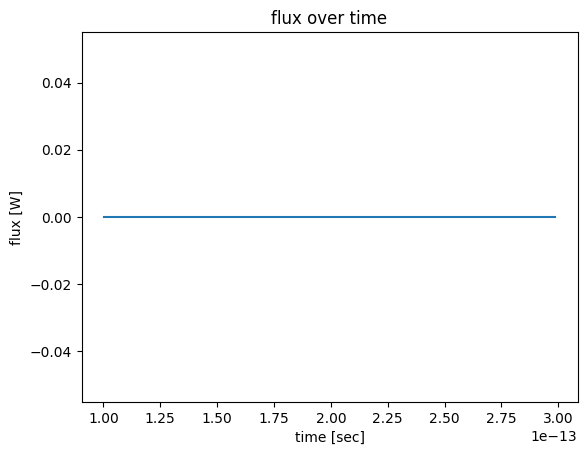

In [24]:
flux_data = sim_data["flux_over_time"].flux
flux_data.plot()
plt.title("flux over time")
plt.show()


For field data, we can further index by `fields` specified in the monitor, as follows.

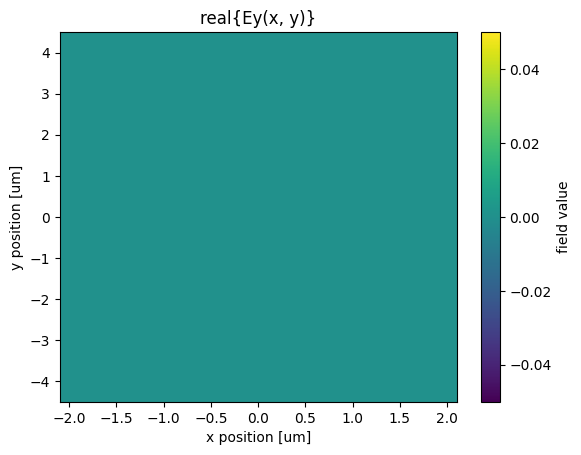

In [25]:
Ey = sim_data["fields_at_150THz"].Ey

Ey.real.plot(x="x", y="y", robust=True)
plt.title("real{Ey(x, y)}")
plt.show()


Finally, [SimulationData](../api/_autosummary/tidy3d.SimulationData.html) provides a method for potting field data with structure overlay, similar to `sim.viz_fields2D()`.

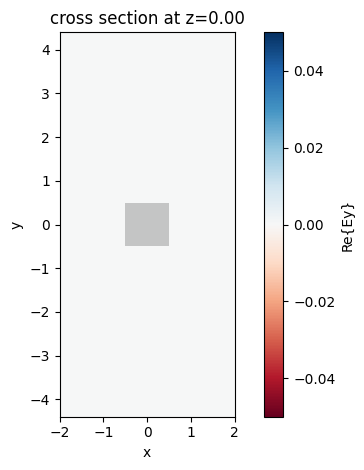

In [26]:
sim_data.plot_field("fields_at_150THz", "Ey", val="real")
plt.show()


## Plugins

Here we will discuss the plugins that support and extend functionalities of Tidy3D, including:

- [Dispersion fitting tool](../notebooks/Fitting.html).

- [Mode solver](../notebooks/ModeSolver.html).

- [Near field to far field transformations](../notebooks/FieldProjections.html).

These plugins are designed to import and make use of Tidy3D components described above, but the Tidy3D components have no dependence on the plugins by design.  In this sense, they can be considered "external" packages that are useful for defining simulation components.

The components from these plugins can be imported as 
```
from tidy3d.plugins.{plugin_name} import {component}
```
for example
```
from tidy3d.plugins.mode import ModeSolver
```

We won't go into the details in this notebook as each of the plugins has its own example tutorial notebook, but here is a summary:

### Dispersion Fitting

We provide a [tool for fitting optical data to create dispersive mediums](../api/_autosummary/tidy3d.plugins.dispersion.DispersionFitter.html).

Given a file or arrays containing wavelength, n, and (optionally) k data, this tool will fit the data to a pole-residue model with some constraints and parameters.

After fitting, the user can visualize and inspect the results.  

This process can be repeated until the user is satisfied, at which point the tool can return a [dispersive medium](../api/_autosummary/tidy3d.PoleResidue.html) for use in the Simulation.

For more details, see the corresponding [tutorial](../notebooks/Fitting.html).

### Mode Solver

The `mode` plugin provides a [mode solver](../api/_autosummary/tidy3d.plugins.mode.ModeSolver.html), which is mainly useful for coming up with [ModeSpec](../api/_autosummary/tidy3d.ModeSpec.html) objects for a given source or monitor.

The tool takes a reference simulation containing some waveguide or other structure definitions to feed to the core solver.  It also requires a [Box](../api/_autosummary/tidy3d.Box.html) specifying the plane on which to solve the modes for.

Then, the user can iteratively send different [ModeSpec](../api/_autosummary/tidy3d.ModeSpec.html) objects, solve for the results, visualize, and repeat the process until satisfied.

The resulting [ModeSpec](../api/_autosummary/tidy3d.ModeSpec.html) can be saved directly, or used in conjunction with the mode solver settings to return a [ModeSource](../api/_autosummary/tidy3d.ModeSource.html) or [ModeMonitor](../api/_autosummary/tidy3d.ModeMonitor.html).

For more details, see the corresponding [tutorial](../notebooks/ModeSolver.html).


### Scattering Matrix

The `smatrix` plugin provides a wrapper for computing S-matrix components using Tidy3D simulations from the [Component Modeler](../api/_autosummary/tidy3d.plugins.smatrix.ComponentModeler.html) plugin.

This tool allows users to connect "ports" to their simulation and post-processes the results into a datastructure that can be queried for S-matrix data.

For more details, see the corresponding [tutorial](../notebooks/SMatrix.html).

### Adjoint

The `adjoint` plugin allows users to write functions involving a Tidy3D `Simulation` run and take efficient gradients of those functions using `jax`. It requires setting up `Simulation` objects using jax-compatible analogues defined in the plugin.

For more details, see the corresponding [tutorial](../notebooks/AdjointPlugin_1_Intro.html).

### Resonance Finder

The `resonance` plugin provides an interface for analyzing time series data using the technique of "harmonic inversion" and using that data to find resonances in the simulation.

For more details, see the corresponding [tutorial](../notebooks/Bandstructure.html).


### PolySlab

The `polyslab` plugin extends the normal `td.PolySlab` functionality to provide more features needed for self-intersecting and complex geometries.

For more details, see the corresponding [tutorial](../notebooks/Self_intersecting_polyslab.html).

## Conclusion

We hope this gives a useful overview of the main changes in the revamped version of Tidy3D.

We highly recommend you check out the various tutorials in our [examples page](https://www.flexcompute.com/tidy3d/examples/). If you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials.  

FDTD simulations can diverge due to various reasons. If you run into any simulation divergence issues, please follow the steps outlined in our [troubleshooting guide](https://www.flexcompute.com/tidy3d/examples/notebooks/DivergedFDTDSimulation/) to resolve it.
